## Part 1: Importing Libraries

In [1]:
from src.modules import data_preprocessing as dp
from src.modules import data_visualization as dv
from src.modules import modeling as md

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## Part 2: Download Dataset

In [2]:
# Declare the ticker symbol. Here we use 5 stocks "AAPL MSFT AMD GOOG META" as an example.
tickers = "AMD"

In [3]:
# Download the data from Yahoo Finance
df = dp.download_data(tickers)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-06,110.559998,111.330002,108.220001,109.279999,109.279999,47736700
2023-09-07,106.139999,107.690002,105.089996,106.589996,106.589996,49080100
2023-09-08,107.019997,109.739998,105.750000,106.089996,106.089996,46232000
2023-09-11,107.320000,107.510002,103.000000,105.320000,105.320000,50556700
2023-09-12,104.199997,106.220001,103.180000,105.250099,105.250099,22346372


## Part 3: EDA & Preprocessing

In [5]:
# Set global style
dv.set_global_style()

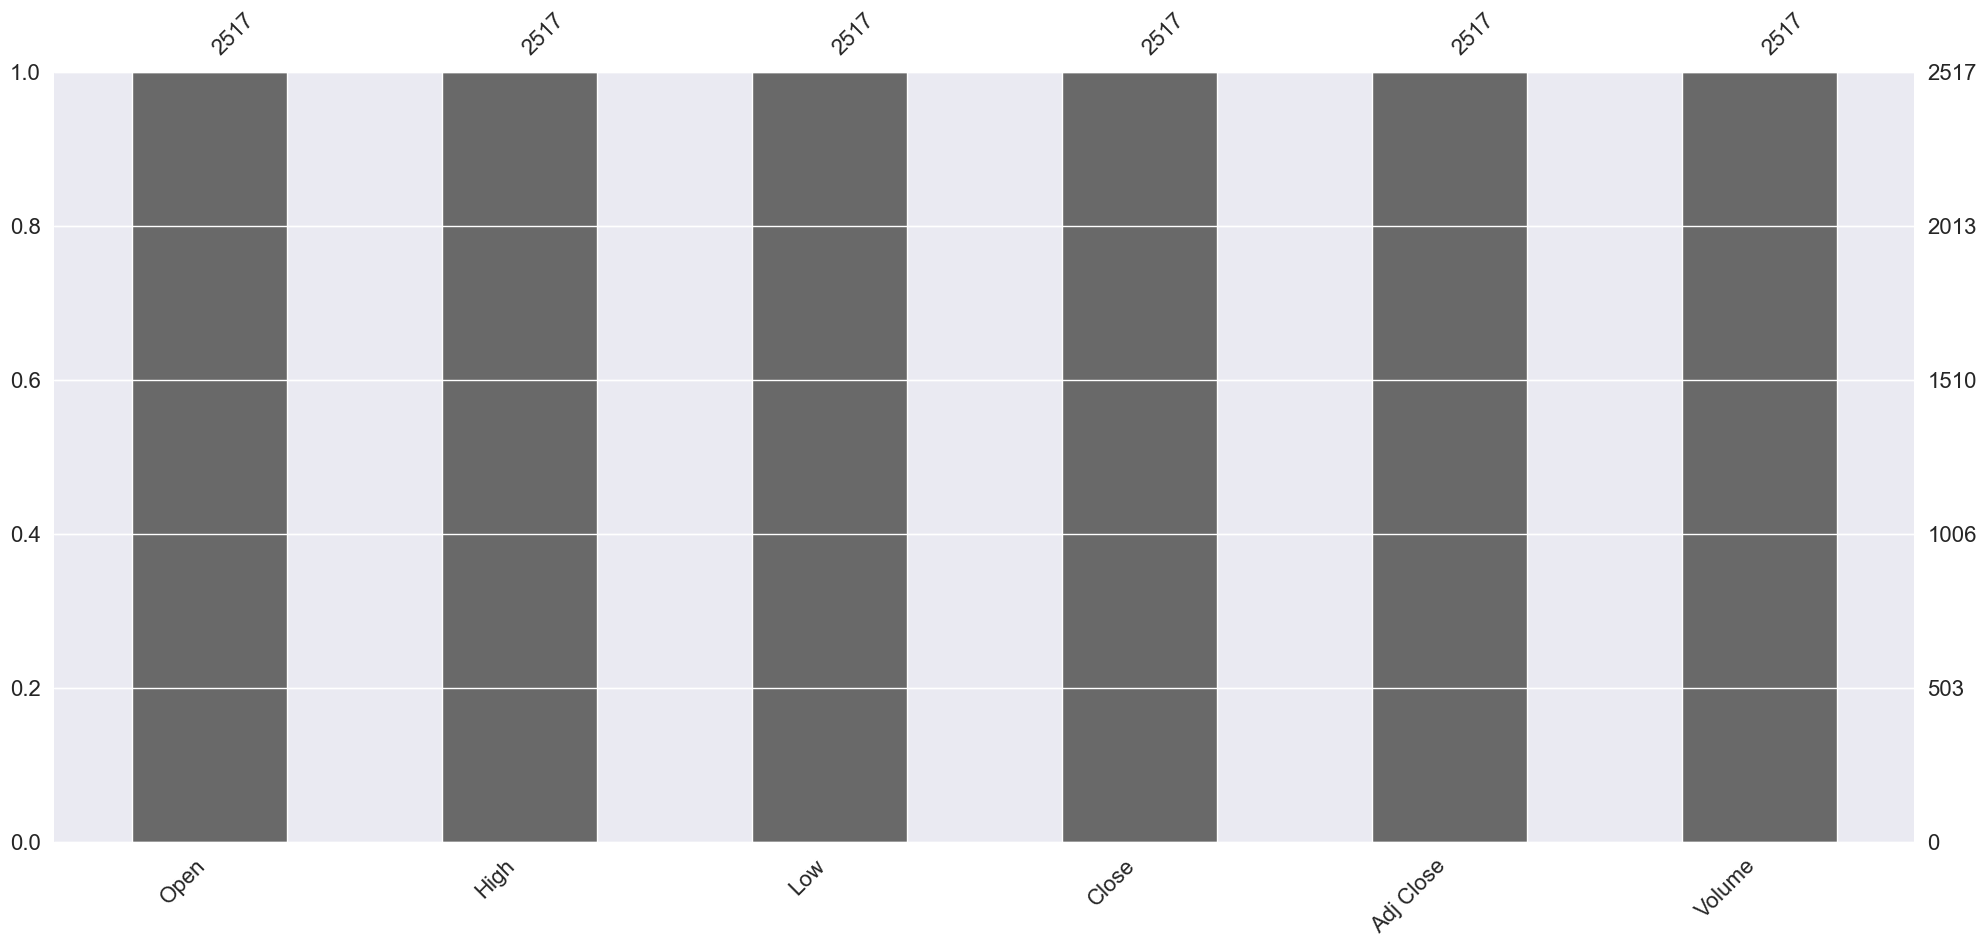

In [6]:
# Checking missing value
dv.plot_missing_values(df)

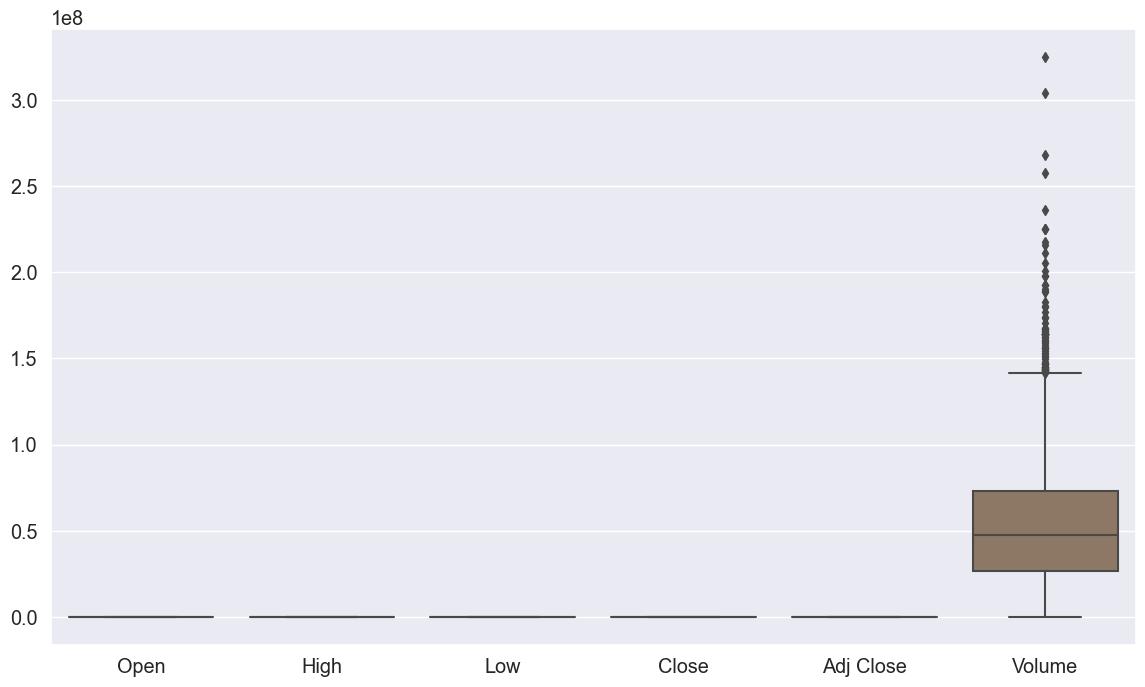

In [7]:
# Visualize the outliers data
dv.plot_outliers(df)

In [8]:
# Clean the data after checking the missing values and outliers
df = dp.clean_data(df)

In [9]:
df.shape

(2517, 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-09-12 to 2023-09-12
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj close  2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [11]:
df.describe()

,adj close
count,2517.000000
mean,39.738455
std,40.732187
min,1.620000
25%,4.130000
50%,19.420000
75%,78.500000
max,161.910004


Summary of EDA
- There are 2518 data points, 6 features
- 5 features are numerical
- There are some outliers in `meta` feature, using data cleaning technique to set the value within an appropriate threshold
- There is no missing nor duplicated values

## Part 4: Data Transformation

In [12]:
feat = ['adj close']

In [13]:
def scale_data(dataframe, feat):
    # get the adj close values
    close_data = dataframe.filter(feat)
    dataset = close_data.values

    # select a subset of the data for training purpose
    # the remaining set of the data is for validation
    # Get 80% of the data for training
    num_training_points = int(np.ceil(len(dataset) * 0.8))
    # X_train = dataset[0:num_training_points, :]
    # X_test = dataset[num_training_points:, :]

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = scaler.fit_transform(dataset)

    # split the data into train and test scaled data sets
    scaled_data_train = scaled_dataset[0:int(num_training_points), :]
    # scaled_data_test = scaled_data[int(num_training_points)-window_size:, :]

    return dataset, scaled_dataset, scaled_data_train, num_training_points, scaler

## Part 5: Feature Engineering

In [14]:
def convert_to_supervised(data, window_size=60):
    # convert the data into a supervised learning problem
    # the number of time steps to look back is the window size
    # the next day's adjusted close price is the label

    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    
    X, y = np.array(X), np.array(y)

    # reshape the data into the shape accepted by the LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y

In [15]:
# Transform the data to supervised learning
window_size = 60 # window size is the number of previous days used to predict the next day. 

In [16]:
def get_features_labels(dataframe, window_size=60):
    dataset, scaled_dataset, scaled_data_train, num_training_points, scaler = scale_data(dataframe, feat)
    features, labels = convert_to_supervised(scaled_data_train, window_size)
    return features, labels, dataset, scaled_dataset, num_training_points, scaler

## Part 6: Modeling

In [22]:
def create_model(features, labels):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    # cp = ModelCheckpoint('model/', save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # Train the model
    # history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1, callbacks=[cp])
    # epoch = 10 for developoment, need to increase to 100 for real training

    return model

In [20]:
features, labels, dataset, scaled_dataset, num_training_points, scaler = get_features_labels(dataframe=df, window_size=60)

In [21]:
print(features.shape)
print(labels.shape)

(1954, 60, 1)
(1954,)


In [23]:
model = create_model(features, labels)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 25)                825       
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1)

In [29]:
# Create the testing data set.
# The testing data set contains the remaining 20% of the data but we have to
# include the last 60 days from the training data set to predict the first stock price of the test data set
scaled_data_test = scaled_dataset[num_training_points - window_size:, :]

# # Create the data sets x_test and y_test
X_test = []
y_test = dataset[num_training_points:, :]

for i in range(60, len(scaled_data_test)):
    X_test.append(scaled_data_test[i-window_size:i, 0])

# Convert the values into arrays for easier computation 
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# scaled_data_test = scaled_data[num_training_points - window_size:, :]
#X_test, y_test = convert_to_supervised(scaled_data_test, window_size)

# predict the testing data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluate result by mse and rmse metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

16/16 [==============================] - 4s 53ms/step
MSE 27.18192457853016
RMSE 5.213628734243565


C:\Users\thong.lam\AppData\Local\Temp\ipykernel_20096\60558138.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


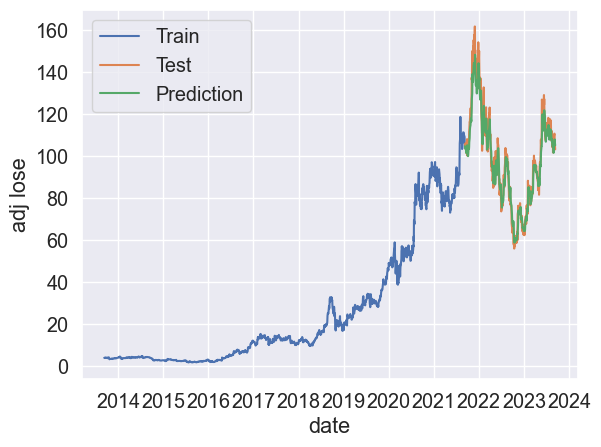

In [30]:
# Ploting the data
import matplotlib.pyplot as plt

df_test = df[['adj close']]
train = df_test[:num_training_points]
test = df_test[num_training_points:]
test['predictions'] = predictions
 
plt.plot(train.index, train['adj close'])
plt.plot(test.index, test[['adj close', 'predictions']])
# plt.title('Daily Stock Price from ' + df.index[0] + ' to ' + df.index[-1])
plt.xlabel('date')
plt.ylabel("adj lose")
plt.legend(['Train', 'Test', 'Prediction'])
# plt.savefig("output/figures/visualizing_testing_data_amd.png", dpi=100)
plt.show()

In [31]:
# Function to generate the future forecasts
def predict(n_past = 0, n_future = 5):

    # prepare data for forecasting
    forecast_data = df[['adj close']].values

    z = scaler.transform(forecast_data)

    X, y = [], []

    for i in range(window_size, len(z)):
        X.append(z[i - window_size: i])
        y.append(z[i])

    X, y = np.array(X), np.array(y)

    X_past = X[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        X_past = np.append(X_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(X_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])
  
    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [32]:
y_pred = predict(n_past=0, n_future=5)

1/1 [==============================] - 0s 37ms/step


In [33]:
print(y_pred)

[103.22221  101.84627  100.949814 100.34952   99.91746 ]


In [90]:
# Save the model for future use
import pickle
pickle.dump(model,open('model_amd.pkl','wb'))

In [34]:
model.save('amd_model.h5')

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
